# Inverse distance weighting - Meuse Dataset

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [51]:
meuse_df = pd.read_csv("meuse_processed.csv")

In [52]:
display(meuse_df)

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460


## Splitting Data

In [53]:
# Convert columns to numpy arrays
observed_location_columns_meuse = ['x', 'y']
observed_values_column_meuse = 'zinc'
observed_locations_meuse = meuse_df[observed_location_columns_meuse].values
observed_values_meuse = meuse_df[observed_values_column_meuse].values

In [54]:
X_train_meuse, X_test_meuse, y_train_meuse, y_test_meuse = train_test_split(observed_locations_meuse,
                                                                            observed_values_meuse, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_meuse.shape}")
print(f"X_test_meuse.shape:  {X_test_meuse.shape}")
print(f"y_train_meuse.shape: {y_train_meuse.shape}")
print(f"y_test_meuse.shape:  {y_test_meuse.shape}")

X_train_meuse.shape: (124, 2)
X_test_meuse.shape:  (31, 2)
y_train_meuse.shape: (124,)
y_test_meuse.shape:  (31,)


## K-Fold Cross Validation

In [55]:
def pred_var(y_true, y_pred):
    
   # Calculate residuals
    residuals = np.array(y_true) - np.array(y_pred)
    
    # Calculate standard deviation of residuals
    sep_resid = np.std(residuals)
    
    return sep_resid

In [56]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]

In [63]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

#For each possible theoratical model, conduct K-Fold CV
for i, power in enumerate((1,2,3,4,5,6)):
    
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []
    cv_scores_sd = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = power)
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        sd = pred_var(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        cv_scores_sd.append(sd)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    mean_validation_score_sd = np.mean(cv_scores_sd)
    
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[power] = {
        "CV Score MAE" : mean_validation_score_mae,
        "CV Score RMSE" : mean_validation_score_rmse,
        "CV Score MAPE" : mean_validation_score_mape,
        "CV Score R Squared" : mean_validation_score_r2,
        "CV Score Prediction SD": mean_validation_score_sd,
        
    }

# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "model": None},
    "CV Score RMSE": {"value": float('inf'), "model": None},
    "CV Score MAPE": {"value": float('inf'), "model": None},
    "CV Score R Squared": {"value": float('-inf'), "model": None},  # Changed to '-inf' for maximization
    "CV Score Prediction SD" : {"value": float('inf'), "model": None},
}

# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

,1,2,3,4,5,6
CV Score MAE,0.408273,0.391944,0.391020,0.394876,0.398866,0.403726
CV Score RMSE,0.519785,0.504509,0.509097,0.520472,0.531599,0.541268
CV Score MAPE,0.068801,0.066370,0.066422,0.067148,0.067847,0.068643
CV Score R Squared,0.474342,0.504510,0.494646,0.470717,0.446684,0.425284
CV Score Prediction SD,0.508854,0.493031,0.496620,0.507342,0.518112,0.527549


The smallest CV Score MAE is 0.3910199097798915, found in power 3.
The smallest CV Score RMSE is 0.5045087606769496, found in power 2.
The smallest CV Score MAPE is 0.06636973489007081, found in power 2.
The largest CV Score R Squared is 0.5045098412535899, found in power 2.
The smallest CV Score Prediction SD is 0.49303061356724526, found in power 2.


### n_neighbors

In [62]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

# For each possible number of neighbors, conduct K-Fold CV
n_neighbors_list = [2, 4, 6, 8, 10, 12,14,16,18,20]
for n_neighbors in n_neighbors_list:
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []
    cv_scores_sd = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = 2, n_neighbors = n_neighbors)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        sd = pred_var(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        cv_scores_sd.append(sd)
        
    # Calculate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    mean_validation_score_sd = np.mean(cv_scores_sd)
    
    # Store the mean CV score for each metric for this iteration of n_neighbors chosen
    cv_score_list[n_neighbors] = {
        "CV Score MAE": mean_validation_score_mae,
        "CV Score RMSE": mean_validation_score_rmse,
        "CV Score MAPE": mean_validation_score_mape,
        "CV Score R Squared": mean_validation_score_r2,
        "CV Score Prediction SD": mean_validation_score_sd
    }

# Display the results
display(pd.DataFrame(cv_score_list))  # Transposed for better readability

smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "model": None},
    "CV Score RMSE": {"value": float('inf'), "model": None},
    "CV Score MAPE": {"value": float('inf'), "model": None},
    "CV Score R Squared": {"value": float('-inf'), "model": None},  # Changed to '-inf' for maximization
    "CV Score Prediction SD" : {"value": float('inf'), "model": None},
}

# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

,2,4,6,8,10,12,14,16,18,20
CV Score MAE,0.411336,0.387136,0.386864,0.391944,0.397741,0.399566,0.404571,0.410444,0.412766,0.418422
CV Score RMSE,0.552665,0.509417,0.504360,0.504509,0.505691,0.502310,0.504332,0.508489,0.507599,0.512061
CV Score MAPE,0.070052,0.065795,0.065438,0.066370,0.067300,0.067706,0.068578,0.069630,0.070042,0.071040
CV Score R Squared,0.395926,0.498708,0.504035,0.504510,0.504421,0.511876,0.508164,0.500764,0.503188,0.495066
CV Score Prediction SD,0.539893,0.500420,0.494007,0.493031,0.494155,0.492357,0.493873,0.498209,0.497932,0.502748


The smallest CV Score MAE is 0.38686370547207505, found in n_neighbors 6.
The smallest CV Score RMSE is 0.5023097658923813, found in n_neighbors 12.
The smallest CV Score MAPE is 0.06543846372025629, found in n_neighbors 6.
The largest CV Score R Squared is 0.5118763190179013, found in n_neighbors 12.
The smallest CV Score Prediction SD is 0.49235688281146495, found in n_neighbors 12.


## Hyperparameter selection

As we can see, power = 2 and n_neighbors = 12 would be the most optimal option.

## Evaluation of Model (Testing Chosen model)

### Performance Metrics of Model

In [64]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]

train_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

x_data_test = [inner_list[0] for inner_list in X_test_meuse]
y_data_test = [inner_list[1] for inner_list in X_test_meuse]

test_data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_meuse
})

eval_combined_array_coordinates = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, train_data['Z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 2, n_neighbors = 12)

rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_test))
mae = mean_absolute_error(test_data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(test_data['Z'], z_pred_test)
r2 = r2_score(test_data['Z'], z_pred_test)
sd = pred_var(test_data['Z'], z_pred_test)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print("Prediction SD:", sd)

MAE: 0.3014827761346395
RMSE: 0.3909725225396918
MAPE: 0.05355569294946698
R Squared: 0.6497636944726171
Prediction SD: 0.36597621317877793


### Plotting Spatial Interpolation of entire area with Model

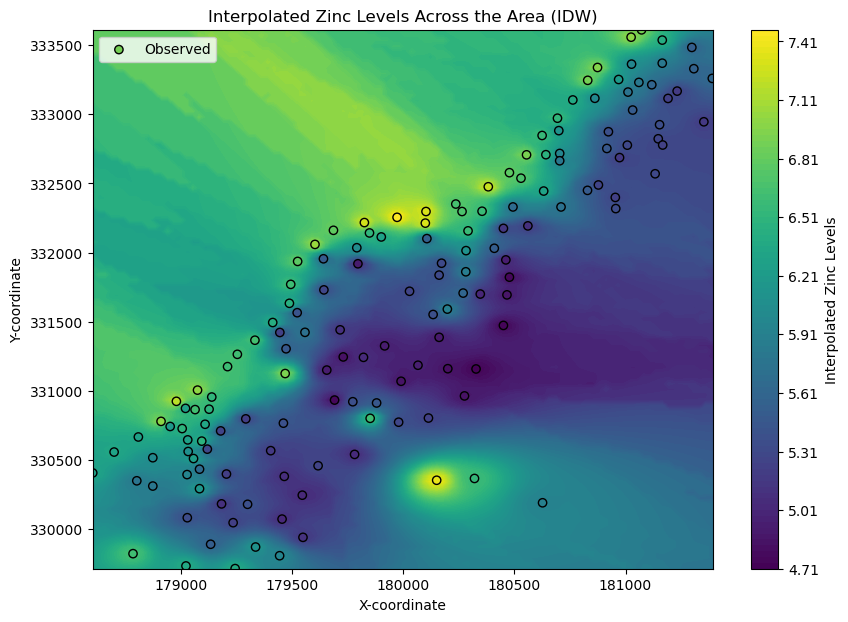

Spatial Interpolation Computation Time: 0.22 seconds


In [65]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 2, n_neighbors = 12)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

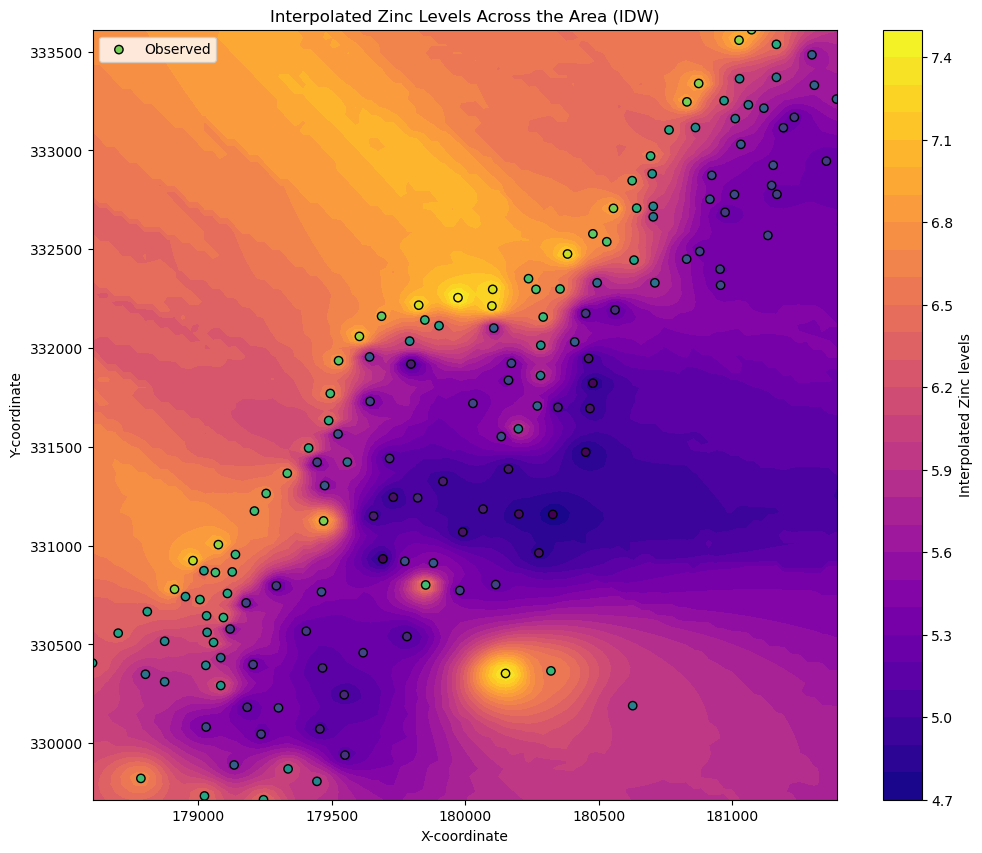

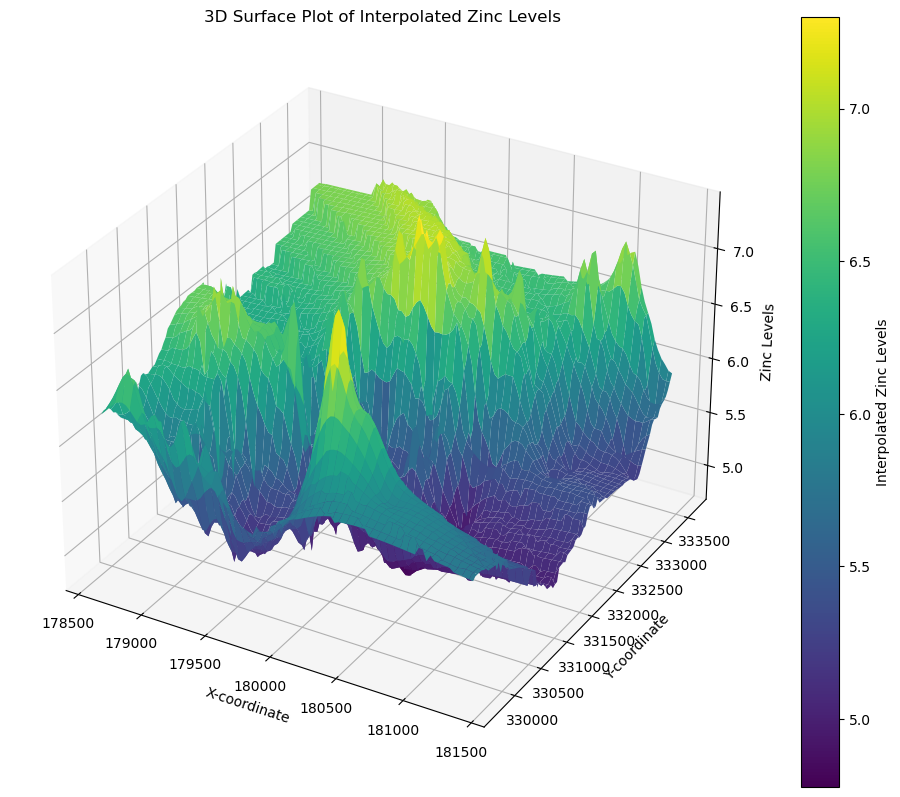

In [66]:
# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
y_min, y_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 2, n_neighbors = 12)
z_grid = interpolated_values.reshape(x_grid.shape)


fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated Zinc levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated Zinc Levels')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Zinc Levels')
ax.set_title('3D Surface Plot of Interpolated Zinc Levels')
plt.show()


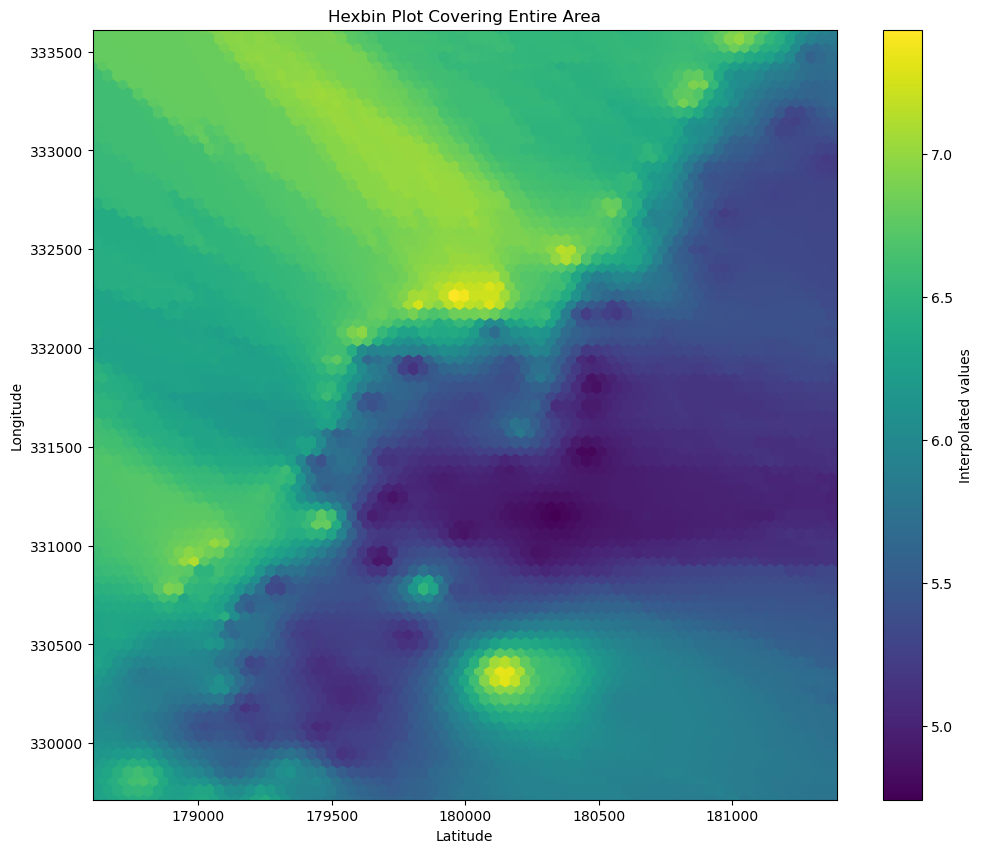

In [67]:
# Determine the minimum and maximum values for Latitude and Longitude
buffer = 0.01
lat_min, lat_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
lon_min, lon_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

# Simulate interpolated_values from your IDW model or similar
interpolated_values = idw_model(combined_array, power=2, n_neighbors=12)

# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=73, cmap='viridis', extent=(lat_min, lat_max, lon_min, lon_max))
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lat_min, lat_max)
plt.ylim(lon_min, lon_max)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Hexbin Plot Covering Entire Area')
plt.show()